# Calculate internal consistency of EEG signals within final sample

Imports

In [1]:
import numpy as np
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel

## Read data

In [5]:
def read_data(file_name, columns=None):
    # Read the data from CSV
    data_df = pd.read_csv(file_name)
    
    # Filter columns based on the provided column names or regex pattern
    if columns is None:
        filtered_columns = data_df.filter(regex=r'^pre_ne_.*z$')
        eeg_columns_name = filtered_columns.columns
    else:
        filtered_columns = data_df[columns]
        eeg_columns_name = columns
    
    # Join the filtered columns with participant_index and pre_acc
    final_data_df = data_df[['participant_index', 'pre_acc']].join(filtered_columns)
    
    return final_data_df

In [6]:
sonata_data_file = os.path.join('../data/current_dataset', 'sonata_data_standardized.csv')
base_data_file = os.path.join('../data/mattes_dataset', 'base_extended_dataset.csv')
acc_data_file = os.path.join('../data/mattes_dataset', 'acc_extended_dataset.csv')
spe_data_file = os.path.join('../data/mattes_dataset', 'spe_extended_dataset.csv')

In [7]:
mattes_columns = ['Ne_FCz_amp']
sonata_data_df = read_data(sonata_data_file, columns='pre_ne_FCz')
base_data_df = read_data(base_data_file, columns=mattes_columns)
acc_data_df = read_data(acc_data_file, columns=mattes_columns)
spe_data_df = read_data(spe_data_file,  columns=mattes_columns)

base_data_df['pre_acc'] = base_data_df['pre_acc'].map(lambda x: 1 if x==0 else -1)
acc_data_df['pre_acc'] = acc_data_df['pre_acc'].map(lambda x: 1 if x==0 else -1)
spe_data_df['pre_acc'] = spe_data_df['pre_acc'].map(lambda x: 1 if x==0 else -1)

datasets = [
    sonata_data_df,
    base_data_df,
    acc_data_df,
    spe_data_df  
]

Define dir for the results

In [12]:
results_path = '../results/consistency_test_results'

## Set condition: ERN (-1) or CRN (1)

In [8]:
acc = 'all'

if acc == 1.0:
    condition = 'crn'
    filtered_datasets = [data_df[data_df['pre_acc'] == acc] for data_df in datasets]
elif acc == -1.0:
    condition = 'ern'
    filtered_datasets = [data_df[data_df['pre_acc'] == acc] for data_df in datasets]
elif acc == 'all':
    condition = 'all'
    filtered_datasets = datasets

### Calculate within-subject variability

In [9]:
def calculate_internal_consistency(data_df, column_name):
    std_pre_ne = data_df.groupby('participant_index')[column_name].std()
    num_trials = data_df.groupby('participant_index')[column_name].count()
    ids = data_df.groupby('participant_index')['participant_index']
    
    between_std = data_df.groupby('participant_index')[column_name].mean().std()
    internal_consistency = between_std**2/(between_std**2 + (std_pre_ne**2/num_trials))
    
    # Create the DataFrame
    variability_df = pd.DataFrame({
        'id': std_pre_ne.index,
        'Personal variance': std_pre_ne,
        'Between subjects variance': between_std,
        'Internal consistency': internal_consistency,    
        'num_trials': num_trials
    })
    
    return variability_df

In [10]:
column_names = ['pre_ne_FCz', 'Ne_FCz_amp',  'Ne_FCz_amp',  'Ne_FCz_amp']
variabilities = [calculate_internal_consistency(data_df, column_name) for data_df, column_name in zip(filtered_datasets, column_names)]

Summary

In [11]:
for dataset_variability in variabilities:
    display(dataset_variability.describe())

,id,Personal variance,Between subjects variance,Internal consistency,num_trials
count,222.000000,222.000000,2.220000e+02,222.000000,222.000000
mean,111.500000,9.763027,4.163804e+00,0.974969,227.112613
std,64.230055,1.896980,8.901856e-16,0.010981,30.666516
min,1.000000,5.489951,4.163804e+00,0.928169,147.000000
25%,56.250000,8.471741,4.163804e+00,0.969749,209.250000
50%,111.500000,9.490011,4.163804e+00,0.977694,233.000000
75%,166.750000,10.995725,4.163804e+00,0.982579,249.000000
max,222.000000,16.381219,4.163804e+00,0.993176,284.000000


,id,Personal variance,Between subjects variance,Internal consistency,num_trials
count,89.000000,89.000000,8.900000e+01,89.000000,89.000000
mean,50.000000,4.979669,1.074669e+00,0.883490,217.685393
std,29.622243,1.621286,2.233027e-16,0.124856,69.509090
min,1.000000,2.006756,1.074669e+00,0.202033,13.000000
25%,25.000000,3.696130,1.074669e+00,0.861157,187.000000
50%,48.000000,4.731009,1.074669e+00,0.916722,229.000000
75%,76.000000,6.099015,1.074669e+00,0.954915,267.000000
max,101.000000,9.060253,1.074669e+00,0.981401,337.000000


,id,Personal variance,Between subjects variance,Internal consistency,num_trials
count,61.000000,61.000000,6.100000e+01,61.000000,61.000000
mean,33.032787,8.251010,3.019214e+00,0.972232,287.147541
std,19.514924,2.272372,8.955493e-16,0.017782,48.919265
min,1.000000,4.702690,3.019214e+00,0.892597,170.000000
25%,16.000000,6.697082,3.019214e+00,0.969429,254.000000
50%,32.000000,7.920730,3.019214e+00,0.976985,296.000000
75%,50.000000,9.035527,3.019214e+00,0.983500,324.000000
max,65.000000,18.528806,3.019214e+00,0.990851,364.000000


,id,Personal variance,Between subjects variance,Internal consistency,num_trials
count,61.000000,61.000000,6.100000e+01,61.000000,61.000000
mean,33.032787,10.873762,2.680296e+00,0.859455,112.475410
std,19.514924,2.876249,8.955493e-16,0.080327,42.174086
min,1.000000,6.898429,2.680296e+00,0.542946,59.000000
25%,16.000000,8.824772,2.680296e+00,0.828189,92.000000
50%,32.000000,10.131997,2.680296e+00,0.887404,109.000000
75%,50.000000,12.389757,2.680296e+00,0.908880,121.000000
max,65.000000,20.427389,2.680296e+00,0.952571,325.000000


Save results

In [13]:
datasets_names = ['Main', 'Mattes-Base', 'Mattes-ACC', 'Mattes-Speed']

for dataset_name, variability_df in zip(datasets_names, variabilities):
    variability_df.to_csv(f'{results_path}/{dataset_name}_{condition}_consistency.csv')
    variability_df.describe().to_csv(f'{results_path}/{dataset_name}_{condition}_consistency_summary.csv')

Plot results

In [14]:
all_datasets_variabilities = pd.DataFrame()
datasets_names = ['Main', 'Mattes-Base', 'Mattes-ACC', 'Mattes-Speed']

for dataset_name, variability_df in zip(datasets_names, variabilities):
    this_df = pd.DataFrame({
        'Internal consistency': variability_df['Internal consistency'],
        'Dataset': dataset_name
    })

    all_datasets_variabilities = pd.concat([all_datasets_variabilities, this_df], ignore_index=True)

/tmp/ipykernel_15949/3050379886.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.violinplot(


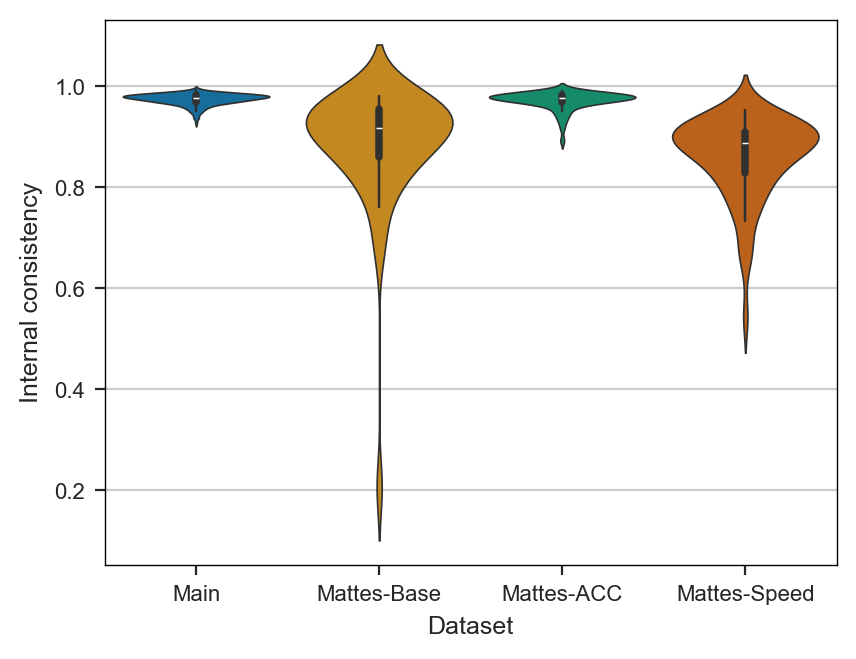

In [15]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [12*cm,9*cm]
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.labelsize'] = 9
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

palette = sns.color_palette('colorblind')

ax = sns.violinplot(
    x='Dataset',
    y = 'Internal consistency', 
    data = all_datasets_variabilities,
    hue='Dataset',
    orient='v',  
    inner="box", 
    cut=2, 
    density_norm='width', 
    linewidth=0.6,
    palette=palette
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"{results_path}/{condition}_consistencies.png",  bbox_inches='tight')

## Test statistical differences between internal consistencies between datasets

In [264]:
concistency_main = all_datasets_variabilities[all_datasets_variabilities['Dataset'] == 'Main']['Internal consistency'].to_numpy()
concistency_base = all_datasets_variabilities[all_datasets_variabilities['Dataset'] == 'Mattes-Base']['Internal consistency'].to_numpy()
concistency_acc = all_datasets_variabilities[all_datasets_variabilities['Dataset'] == 'Mattes-ACC']['Internal consistency'].to_numpy()
concistency_spe = all_datasets_variabilities[all_datasets_variabilities['Dataset'] == 'Mattes-Speed']['Internal consistency'].to_numpy()

- Main and ACC

In [265]:
ttest_ind(concistency_main, concistency_acc, nan_policy='omit')

TtestResult(statistic=6.074003696134285, pvalue=4.088919959628949e-09, df=278.0)

- Main and Base

In [266]:
ttest_ind(concistency_main, concistency_base, nan_policy='omit')

TtestResult(statistic=13.530310562499102, pvalue=4.678113713176908e-33, df=308.0)

- Main and Speed

In [267]:
ttest_ind(concistency_main, concistency_spe, nan_policy='omit')

TtestResult(statistic=13.31905011624198, pvalue=1.0464226681303974e-31, df=281.0)

- Base and ACC

In [268]:
ttest_ind(concistency_base, concistency_acc, nan_policy='omit')

TtestResult(statistic=-4.385211311080971, pvalue=2.2228793319242432e-05, df=144.0)

- Base and Speed

In [269]:
ttest_ind(concistency_base, concistency_spe, nan_policy='omit')

TtestResult(statistic=-1.623710716778422, pvalue=0.10658001518666152, df=147.0)

- ACC and Speed

In [270]:
ttest_ind(concistency_acc, concistency_spe, nan_policy='omit')

TtestResult(statistic=3.391537387810811, pvalue=0.000948644051460948, df=117.0)